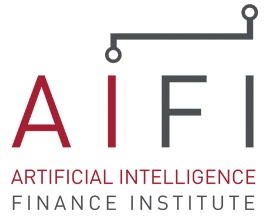


# Bootcamp - Python and Coding - Deep Learning

## Open notebook in: 
| Colab                                 | Gradient                                                                                                                                         |
|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nicolepcx/Transformers-in-Action/blob/main/CH03/ch03_text_summarization_fine_tuning.ipynb)                                              | [![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/Nicolepcx/Transformers-in-Action/blob/main/CH03/ch03_text_summarization_fine_tuning.ipynb)|             

# Download repo

In [1]:
# Clone repo, if it's not already cloned, to be sure all runs on smoothly
# on Colab, Kaggle or Paperspace
import os

if not os.path.isdir('Transformers-in-Action'):
    !git clone https://github.com/Nicolepcx/Transformers-in-Action.git
else:
    print('Repository already exists. Skipping clone.')


current_path = %pwd
if '/Transformers-in-Action' in current_path:
    new_path = current_path + '/utils'
else:
    new_path = current_path + '/Transformers-in-Action/utils'
%cd $new_path


Cloning into 'Transformers-in-Action'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 119 (delta 54), reused 75 (delta 30), pack-reused 0
Receiving objects: 100% (119/119), 573.37 KiB | 22.05 MiB/s, done.
Resolving deltas: 100% (54/54), done.
/content/Transformers-in-Action/utils


# About this notebook

In this notebook, we will fine-tune the Facebook/BART-large-cnn model on the BillSum dataset. In the previous notebook, we explored and evaluated various text summarization models, including BART, and now we will take the next step by adapting the BART model specifically for summarizing legislative text data.

Fine-tuning a pre-trained model can be a challenging process, as it requires a good understanding of the dataset, model architecture, and the underlying task. The process often involves hyperparameter optimization to find the best combination of settings that yield optimal performance. However, in this notebook, we will stick to the recommended model settings to simplify the fine-tuning process.

In this notebook, you will:

1. Gain an understanding of the fine-tuning process, its challenges, and the importance of hyperparameter optimization.
2. Learn how to prepare the BillSum dataset for the fine-tuning process, including data preprocessing and splitting.
3. Explore the recommended settings for the Facebook/BART-large-cnn model and understand their significance in the fine-tuning process.
4. Implement the fine-tuning process using the recommended settings and observe how the model adapts to the legislative text data.
5. Evaluate the fine-tuned model on multiple samples from the BillSum dataset, considering ROUGE as a comparison.
6. Discuss the implications of fine-tuning with the recommended settings and the potential benefits of hyperparameter optimization for achieving better performance.

By the end of this notebook, you will have a deeper understanding of the fine-tuning process, the challenges involved, and the importance of hyperparameter optimization. You will also gain practical experience in fine-tuning the Facebook/BART-large-cnn model on the BillSum dataset and evaluating its performance on legislative text data. Let's dive into the fascinating world of fine-tuning and enhance the capabilities of our text summarization model!

# Install requirements

In [2]:
from requirements import *

In [3]:
install_base_packages()
install_required_packages_ch03()

Installing base requirements...

✅ transformers==4.26.1 installation completed successfully!

✅ datasets==2.10.1 installation completed successfully!

Installing chapter 3 requirements...

✅ summa==1.2.0 installation completed successfully!

✅ evaluate==0.4.0 installation completed successfully!

✅ rouge_score==0.1.2 installation completed successfully!

✅ sentencepiece installation completed successfully!



# Imports

In [4]:
from setup import *
from utils import *

In [5]:
useGPU()

Have fun with this chapter!🥳


# Allocate enough RAM

Let us try to get a __GPU__ with at least __15GB RAM__ for our notebook.

In [6]:
# crash colab to get more RAM -> uncomment to use
#!kill -9 -1

We can execute the following command `!free -h`  to see if we have enough RAM and `!nvidia-smi` to get more info about our GPU type we got assigned.
If the allocated GPU is too small, the above cell can be used to run the command to crash the notebook hoping to get a better GPU after the crash, since the GPU is randomly allocated.


In [7]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           83Gi       1.2Gi        78Gi       2.0Mi       4.2Gi        81Gi
Swap:            0B          0B          0B


In [8]:
!nvidia-smi

Tue Apr  4 15:42:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    46W / 400W |      3MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
import torch

if torch.cuda.is_available():
    gpu_device = torch.device('cuda')
    gpu_info = torch.cuda.get_device_properties(gpu_device)
    gpu_memory = gpu_info.total_memory / 1e9  # Convert bytes to gigabytes
    print(f"GPU: {gpu_info.name}, Total Memory: {gpu_memory:.2f} GB")
else:
    print("No GPU detected.")


GPU: NVIDIA A100-SXM4-40GB, Total Memory: 42.48 GB


In [10]:

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb=32"


In [11]:
import datasets
from datasets import load_dataset
from transformers import BartForConditionalGeneration, BartTokenizer, Trainer, TrainingArguments 
from transformers import EarlyStoppingCallback, DataCollatorForSeq2Seq, set_seed
from evaluate import load as load_evaluate_metric
from transformers.trainer_utils import EvalPrediction
import numpy as np
import warnings
from transformers import logging
from transformers import EvalPrediction
from datasets import load_metric
import evaluate



In [12]:
set_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [13]:

# Load the BillSum dataset
dataset = load_dataset("billsum")

# Load BART tokenizer and model
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")


Generating train split:   0%|          | 0/18949 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3269 [00:00<?, ? examples/s]

Generating ca_test split:   0%|          | 0/1237 [00:00<?, ? examples/s]

Dataset billsum downloaded and prepared to /root/.cache/huggingface/datasets/billsum/default/3.0.0/75cf1719d38d6553aa0e0714c393c74579b083ae6e164b2543684e3e92e0c4cc. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [14]:
dataset


DatasetDict({
    train: Dataset({
        features: ['text', 'summary', 'title'],
        num_rows: 18949
    })
    test: Dataset({
        features: ['text', 'summary', 'title'],
        num_rows: 3269
    })
    ca_test: Dataset({
        features: ['text', 'summary', 'title'],
        num_rows: 1237
    })
})

## Data Preprocessing and Subset Selection



In this code snippet, we define a preprocessing function and apply it to a subset of the BillSum dataset for both training and testing purposes. The primary objective of this code is to prepare the data for the fine-tuning process of the Facebook/BART-large-cnn model, which we will use for legislative text summarization.

1. `preprocess_function`: This function takes an example from the dataset, tokenizes the input text and the corresponding summary, and returns the input and target encodings in the required format. The input text is truncated or padded to a maximum length of 1024 tokens, while the summary is limited to 128 tokens.

2. `set_range`: We set a range of 420 to select a subset of the dataset for training and testing purposes. This allows us to reduce the computational resources needed for the fine-tuning process while still providing a representative sample of the dataset.

3. `subset_train` and `subset_test`: We select the specified range of examples from the "train" and "ca_test" splits of the dataset and apply the preprocess_function to each example using the `map()` function. This results in preprocessed training and testing subsets.

4. `set_format`: We set the format of both subset_train and subset_test to "torch", which allows us to work with PyTorch tensors directly. We also specify the columns to include in the format: "input_ids", "attention_mask", and "labels".

By applying this code, we efficiently preprocess and prepare the BillSum dataset for the fine-tuning process, ensuring that the data is compatible with the Facebook/BART-large-cnn model and facilitating an effective training and evaluation workflow.

In [15]:
def preprocess_function(example):
    input_encoding = tokenizer(example["text"], max_length=1024, truncation=True, padding="max_length", return_tensors="pt")
    target_encoding = tokenizer(example["summary"], max_length=128, truncation=True, padding="max_length", return_tensors="pt")
    return {"input_ids": input_encoding["input_ids"][0], "attention_mask": input_encoding["attention_mask"][0], "labels": target_encoding["input_ids"][0]}


subset_train = dataset["train"].select(range(800)).map(preprocess_function)
subset_test = dataset["ca_test"].select(range(400)).map(preprocess_function)

subset_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
subset_test.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

In [16]:
subset_train

Dataset({
    features: ['text', 'summary', 'title', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 800
})

## Computing ROUGE Scores for Model Evaluation


This code snippet defines a function called compute_rouge, which calculates the ROUGE score for the model's predictions during evaluation. The function takes an EvalPrediction object as input, which contains the model's generated predictions and the corresponding reference summaries (ground truth).

Here's a step-by-step explanation of the function:

1. `rouge = evaluate.load('rouge')`: We load the ROUGE metric from the Hugging Face datasets library using the load() function. This metric will be used to calculate the similarity between the model's predictions and the reference summaries.

2. `predictions = tokenizer.batch_decode(eval_prediction.predictions, skip_special_tokens=True)`: We decode the model's predictions stored in `eval_prediction`.predictions using the tokenizer's `batch_decode()` function. We set skip_special_tokens=True to remove any special tokens (e.g., padding or EOS tokens) from the decoded text.

3. `references = tokenizer.batch_decode(eval_prediction.label_ids, skip_special_tokens=True)`: Similarly, we decode the reference summaries (ground truth) stored in `eval_prediction.label_ids` using the tokenizer's `batch_decode()` function, while also removing any special tokens.

4. `return rouge.compute(predictions=predictions, references=references)`: We compute the ROUGE score using the `rouge.compute()` function with the decoded predictions and reference summaries as input. The function returns the calculated ROUGE scores, which serve as the evaluation metric for the model's performance.

We need this function for the Trainer class provided by the Hugging Face transformers library. The Trainer class requires a custom function to compute metrics during the evaluation phase. By defining compute_rouge, we can integrate the ROUGE metric into the training and evaluation workflow, allowing us to assess the model's performance in generating summaries.

In [17]:
def compute_rouge(eval_prediction: EvalPrediction):
    rouge = evaluate.load('rouge')
    predictions = tokenizer.batch_decode(eval_prediction.predictions, skip_special_tokens=True)
    references = tokenizer.batch_decode(eval_prediction.label_ids, skip_special_tokens=True)

    return rouge.compute(predictions=predictions, references=references)



## Setting Up Training Arguments and Initializing Data Collator




This code snippet sets up the training arguments and initializes a data collator for fine-tuning the text summarization model. The TrainingArguments class from the Hugging Face transformers library is used to define various hyperparameters and settings for the training process.

1. `output_dir`: Specifies the directory where the trained model and related files will be saved.
2. `num_train_epochs`: Sets the number of training epochs to 3, which is within the recommended range.
3. `learning_rate`: Sets the learning rate to 3e-5, which is the recommended value for this model.
4. `per_device_train_batch_size` and `per_device_eval_batch_size`: Set the batch size for training and evaluation to 8, as recommended.
5. `gradient_accumulation_steps`: Sets the number of steps to accumulate gradients before performing an optimizer step. The recommended value of 1 is used here.
6. `warmup_steps`: Specifies the number of warm-up steps for the learning rate scheduler. The recommended value of 500 is used.
7. `weight_decay`: Sets the weight decay for the optimizer to 0.01, as recommended.
8. `logging_dir, logging_steps`: Define the directory for logging and the number of steps between each logging.
9. `evaluation_strategy`, `eval_steps`: Set the evaluation strategy to 'steps' and the number of steps between each evaluation to 160.
10. `load_best_model_at_end`: Indicates whether to load the best model found during training at the end of the process.
11. `save_steps`: Specifies the number of steps between each checkpoint save.
12. `seed`: Sets the random seed for reproducibility.
13. `report_to`: Disables reporting to external platforms by setting it to 'none'.

Next, the `DataCollatorForSeq2Seq` class is used to initialize a data collator. This collator is responsible for preparing batches of data during training. It takes the tokenizer, model, padding setting, and maximum length as input. The data collator ensures that the input sequences are padded or truncated to the specified maximum length (1024 tokens) and organizes the data into the required format for training the seq2seq model.

In [18]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,                 # Keep this as it is within the recommended range
    learning_rate=3e-5,                 # Use the recommended learning rate
    per_device_train_batch_size=8,      # Use  the recommended batch size
    per_device_eval_batch_size=8,       # Use the recommended batch size
    gradient_accumulation_steps=1,      # Use the recommended -> 1 by default
    warmup_steps=500,                   # Use the recommended warm-up steps
    weight_decay=0.01,                  # Use the recommended value
    logging_dir='logs',
    logging_steps=160,
    evaluation_strategy='steps',
    eval_steps=160,
    load_best_model_at_end=True,
    save_steps=160,
    seed=42,
    report_to='none'
)


# Initialize the data collator
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, padding=True, max_length=1024)


## Fine-Tuning the Model with Trainer and Early Stopping Callback



This code snippet initializes and trains a Trainer object from the Hugging Face transformers library, which simplifies the fine-tuning process for our text summarization model. The Trainer class provides a high-level interface for training, fine-tuning, and evaluating models, streamlining the overall process and reducing boilerplate code.

The Trainer object is initialized with the following parameters:

1. `model`: The pre-trained model to be fine-tuned.
2. `args`: The TrainingArguments object containing the hyperparameters and settings for the training process.
3. `train_dataset` and `eval_dataset`: The preprocessed training and evaluation subsets of the BillSum dataset.
4. `compute_metrics`: The custom metric function, compute_rouge, which calculates ROUGE scores during evaluation.
5. `data_collator`: The DataCollatorForSeq2Seq object responsible for preparing batches of data during training.
6. `callbacks`: A list of callbacks, including the EarlyStoppingCallback, which monitors training progress and stops training if there is no significant improvement in the evaluation metric within a specified number of evaluation steps.

The benefits of using the Trainer class include:

- Simplified training and evaluation loop, allowing for easy implementation and reduced development time.
- Built-in support for distributed training and mixed precision, improving training efficiency.
- Automatic handling of learning rate scheduling, optimization, and gradient accumulation.
- Integration with custom metric functions, such as compute_rouge, for model evaluation.
- The EarlyStoppingCallback is an optional feature that monitors the model's performance during training and stops the process early if there is no significant improvement within a specified number of evaluation steps. This callback helps prevent overfitting and can save time and computational resources by terminating training when the model's performance plateaus.

In this code snippet, the EarlyStoppingCallback is set to monitor the evaluation metric with a patience of 10 evaluation steps and a minimum improvement threshold of 0.001. If the metric does not improve by at least 0.001 within 10 evaluation steps, the training process will be terminated.

Finally, the trainer.train() function is called to start the fine-tuning process for the text summarization model using the specified parameters and settings.

In [19]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=subset_train,
    eval_dataset=subset_test,
    compute_metrics=compute_rouge,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(10, 0.001)]
)


trainer.train()


The following columns in the training set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: title, summary, text. If title, summary, text are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 800
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 100
  Number of trainable parameters = 406290432
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2357: UserWarning: `max_length` is 

Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=100, training_loss=2.9133895874023437, metrics={'train_runtime': 87.6045, 'train_samples_per_second': 9.132, 'train_steps_per_second': 1.141, 'total_flos': 1733683681689600.0, 'train_loss': 2.9133895874023437, 'epoch': 1.0})

In [20]:
#print(dataset["test"]["text"][0])
type(dataset["ca_test"]["summary"][0])

str

In [21]:
# This line suppresses UserWarnings originating from the transformers module. 
# By setting the filter to ignore warnings, you can avoid having your notebook 
# cluttered with potentially unnecessary warning messages while running your code.
warnings.filterwarnings("ignore", category=UserWarning, module="transformers")

# This line sets the verbosity level of the logging messages to ERROR. By doing 
# this, only error messages will be displayed in the notebook, hiding other log 
# messages with lower severity levels such as DEBUG, INFO, and WARNING. 
# This helps to keep the notebook output focused on errors that may require 
# your attention.
logging.set_verbosity(logging.ERROR)


## Function for Generating Summaries with a Fine-Tuned Mode



Info: This code defines a function called `generate_summary`, which takes a fine-tuned model, tokenizer, and an input text as arguments. The function generates a summary for the given input text using the model and tokenizer.

1. The device variable is set to use a GPU if available, otherwise, it falls back to using the CPU.
2. The model is moved to the appropriate device using model.to(device).
3. The `max_length` variable is set to the tokenizer's model maximum length.
4. The input text is split into chunks based on the `max_length` to avoid exceeding the model's token limit.
5. An empty list called summaries is initialized to store the generated summaries for each chunk.
6. The function iterates over each chunk, encoding it using the tokenizer and moving the encoding to the appropriate device.
7. The `model.generate()` function is called with the input encoding, specifying parameters like `max_length`, `min_length`, length_penalty, and num_beams to control the generation process.
8. The generated summary is decoded using the tokenizer and appended to the summaries list.
9. The final summary is created by joining the summaries of each chunk using spaces and returned by the function.

This function can be used to generate summaries for long input texts with the fine-tuned model and tokenizer.

In [25]:
def generate_summary(model, tokenizer, input_text):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    max_length = tokenizer.model_max_length
    chunks = [input_text[i:i + max_length] for i in range(0, len(input_text), max_length)]

    summaries = []
    for chunk in chunks:
        # pt = return PyTorch tensors
        input_encoding = tokenizer(chunk, max_length=max_length, truncation=True, return_tensors="pt")
        input_encoding = input_encoding.to(device)

        summary_ids = model.generate(input_encoding["input_ids"], max_length=128, length_penalty=2.0, num_beams=4)
        summary_text = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        summaries.append(summary_text)

    summary = " ".join(summaries)
    return summary


## Evaluating the Model on 10 Test Samples and Computing ROUGE Scores



This following code evaluates the fine-tuned model on 10 samples from the test dataset and computes the ROUGE scores for the generated summaries.

- `generated_summaries`: A list comprehension is used to call the generate_summary function for each of the first 10 samples in the ca_test dataset. This generates a list of summaries produced by the model for each input text.

- `reference_summaries`: A list comprehension is used to extract the first 10 reference summaries from the ca_test dataset. These reference summaries serve as the ground truth for comparison with the generated summaries.

- `rouge = evaluate.load('rouge')`: The ROUGE evaluation metric is loaded using the evaluate library.

- `rouge_scores`: The rouge.compute() method is called with the predictions (generated_summaries) and references (reference_summaries) as its arguments. This computes the ROUGE scores (ROUGE-1, ROUGE-2, ROUGE-L, and ROUGELsum) for the generated summaries compared to the reference summaries.

We evaluate the model on different variants of ROUGE, which consider different aspects of the summaries, such as n-grams and the longest common subsequence. ROUGE was introduced in the paper titled "[ROUGE: A Package for Automatic Evaluation of Summaries](https://aclanthology.org/W04-1013.pdf)" by Chin-Yew Lin in 2004

__Note__: It's good practice to evaluate your model on different metrics and also compare it to a state-of-the-art model using the same dataset, if available. 

In [26]:
# Evaluate the model on 10 samples
generated_summaries = [generate_summary(model, tokenizer, dataset["ca_test"]["text"][i]) for i in range(10)]
reference_summaries = [dataset["ca_test"]["summary"][i] for i in range(10)]

rouge = evaluate.load('rouge')
rouge_scores = rouge.compute(predictions=generated_summaries, references=reference_summaries)
print(rouge_scores)


{'rouge1': 0.4464194975454907, 'rouge2': 0.21790548260215242,
'rougeL': 0.24394461122155806, 'rougeLsum': 0.32512553477297335}


In [27]:
# Create data
pd.DataFrame.from_records(rouge_scores, index=["BART"])

,rouge1,rouge2,rougeL,rougeLsum
BART,0.446419,0.217905,0.243945,0.325126


In [28]:
 print(dataset["ca_test"]["text"][0])

The people of the State of California do enact as follows:


SECTION 1.
The Legislature finds and declares all of the following:
(a) (1) Since 1899 congressionally chartered veterans’ organizations
have provided a valuable service to our nation’s returning service
members. These organizations help preserve the memories and incidents
of the great hostilities fought by our nation, and preserve and
strengthen comradeship among members.
(2) These veterans’ organizations also own and manage various
properties including lodges, posts, and fraternal halls. These
properties act as a safe haven where veterans of all ages and their
families can gather together to find camaraderie and fellowship, share
stories, and seek support from people who understand their unique
experiences. This aids in the healing process for these returning
veterans, and ensures their health and happiness.
(b) As a result of congressional chartering of these veterans’
organizations, the United States Internal Revenue Serv

In [29]:
print(generated_summaries[0])

Since 1899, congressionally chartered veterans' organizations have
provided a valuable service to our nation's returning service members.
These organizations help preserve the memories and incidents of the
great hostilities fought by our nation, and preserve and strengthen
comradeship among members. (2) These veterans’ organizations also own
and manage various properties including lodges, posts, and fraternal
halls. Post or organization that carries on programs to perpetuate the
memory of deceased veterans and members of the Armed Forces and to
comfort their survivors, conducts programs for religious, charitable,
scientific, literary, or educational purposes, sponsors or
participates in activities of a patriotic nature, and provides social
and recreational activities for their members. American Legion,
chartered by the Congress of the United States, organized and operated
for charitable purposes, when the same are used solely and exclusively
for the purpose of the organization, if not 

In [30]:
print(reference_summaries[0])

Existing property tax law establishes a veterans’ organization
exemption under which property is exempt from taxation if, among other
things, that property is used exclusively for charitable purposes and
is owned by a veterans’ organization.
This bill would provide that the veterans’ organization exemption
shall not be denied to a property on the basis that the property is
used for fraternal, lodge, or social club purposes, and would make
specific findings and declarations in that regard. The bill would also
provide that the exemption shall not apply to any portion of a
property that consists of a bar where alcoholic beverages are served.
Section 2229 of the Revenue and Taxation Code requires the Legislature
to reimburse local agencies annually for certain property tax revenues
lost as a result of any exemption or classification of property for
purposes of ad valorem property taxation.
This bill would provide that, notwithstanding Section 2229 of the
Revenue and Taxation Code, no appro